If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [ ]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 5.3 MB/s 
     |████████████████████████████████| 5.3 MB 60.2 MB/s 
     |████████████████████████████████| 163 kB 67.8 MB/s 
     |████████████████████████████████| 95 kB 5.2 MB/s 
     |████████████████████████████████| 115 kB 65.6 MB/s 
     |████████████████████████████████| 212 kB 51.3 MB/s 
     |████████████████████████████████| 127 kB 57.2 MB/s 
     |████████████████████████████████| 7.6 MB 45.1 MB/s 
     |████████████████████████████████| 115 kB 57.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

```python
from huggingface_hub import notebook_login

notebook_login()
```

Then you need to install Git-LFS. Uncomment the following instructions:

In [ ]:
 !apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [ ]:
import transformers

print(transformers.__version__)

4.23.1


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/question-answering).

# Fine-tuning a model on a question-answering task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a question answering task, which is the task of extracting the answer to a question from a given context. We will see how to easily load a dataset for these kinds of tasks and use the `Trainer` API to fine-tune a model on it.

**Note:** This notebook finetunes models that answer question by taking a substring of a context, not by generating new text.

This notebook is built to run on any question answering task with the same format as SQUAD (version 1 or 2), with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a token classification head and a fast tokenizer (check on [this table](https://huggingface.co/transformers/index.html#bigtable) if this is the case). It might just need some small adjustments if you decide to use a different dataset than the one used here. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [ ]:
# This flag is the difference between SQUAD v1 or 2 (if you're using another dataset, it indicates if impossible
# answers are allowed or not).
squad_v2 = False
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [ ]:
from datasets import load_dataset, load_metric

For our example here, we'll use the [SQUAD dataset](https://rajpurkar.github.io/SQuAD-explorer/). The notebook should work with any question answering dataset provided by the 🤗 Datasets library. If you're using your own dataset defined from a JSON or csv file (see the [Datasets documentation](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) on how to load them), it might need some adjustments in the names of the columns used.

In [ ]:
# datasets = load_dataset("squad_v2" if squad_v2 else "squad") #full dataset
datasets = load_dataset("squad_v2" if squad_v2 else "squad",  split=['train[:10%]', 'validation[:10%]'])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

The `datasets` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [ ]:
datasets

[Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 8760
 }), Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 1057
 })]

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

To access an actual element, you need to select a split first, then give an index:

In [ ]:
# datasets["train"][0]
datasets[0][0]


{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [ ]:
import random
# random.choice(datasets['train'])
random.choice(datasets[0])


{'id': '56d43da72ccc5a1400d830c0',
 'title': 'Beyoncé',
 'context': 'Following the disbandment of Destiny\'s Child in June 2005, she released her second solo album, B\'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". Beyoncé also ventured into acting, with a Golden Globe-nominated performance in Dreamgirls (2006), and starring roles in The Pink Panther (2006) and Obsessed (2009). Her marriage to rapper Jay Z and portrayal of Etta James in Cadillac Records (2008) influenced her third album, I Am... Sasha Fierce (2008), which saw the birth of her alter-ego Sasha Fierce and earned a record-setting six Grammy Awards in 2010, including Song of the Year for "Single Ladies (Put a Ring on It)". Beyoncé took a hiatus from music in 2010 and took over management of her career; her fourth album 4 (2011) was subsequently mellower in tone, exploring 1970s funk, 1980s pop, and 1990s soul. Her critically acclaimed fifth studio album, Beyoncé (2013), was distinguished 

We can see the answers are indicated by their start position in the text (here at character 515) and their full text, which is a substring of the context as we mentioned above.

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing).

In [ ]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))
    # display(df)


In [ ]:
# show_random_elements(datasets["train"])
show_random_elements(datasets[0])


,id,title,context,question,answers
0,56bf7cb63aeaaa14008c9679,Beyoncé,"The group changed their name to Destiny's Child in 1996, based upon a passage in the Book of Isaiah. In 1997, Destiny's Child released their major label debut song ""Killing Time"" on the soundtrack to the 1997 film, Men in Black. The following year, the group released their self-titled debut album, scoring their first major hit ""No, No, No"". The album established the group as a viable act in the music industry, with moderate sales and winning the group three Soul Train Lady of Soul Awards for Best R&B/Soul Album of the Year, Best R&B/Soul or Rap New Artist, and Best R&B/Soul Single for ""No, No, No"". The group released their multi-platinum second album The Writing's on the Wall in 1999. The record features some of the group's most widely known songs such as ""Bills, Bills, Bills"", the group's first number-one single, ""Jumpin' Jumpin'"" and ""Say My Name"", which became their most successful song at the time, and would remain one of their signature songs. ""Say My Name"" won the Best R&B Performance by a Duo or Group with Vocals and the Best R&B Song at the 43rd Annual Grammy Awards. The Writing's on the Wall sold more than eight million copies worldwide. During this time, Beyoncé recorded a duet with Marc Nelson, an original member of Boyz II Men, on the song ""After All Is Said and Done"" for the soundtrack to the 1999 film, The Best Man.","Debut song, ""Killing Time"" was featured on what movie's sound track?","{'text': ['Men in Black'], 'answer_start': [215]}"
1,56db2cc2e7c41114004b4eb9,American_Idol,"Phillips released ""Home"" as his coronation song, while Sanchez released ""Change Nothing"". Phillips' ""Home"" has since become the best selling of all coronation songs.",What was Phillip's coronation song?,"{'text': ['Home'], 'answer_start': [19]}"
2,573425ecd058e614000b6a09,Portugal,"People are usually well informed about their health status, the positive and negative effects of their behaviour on their health and their use of health care services. Yet their perceptions of their health can differ from what administrative and examination-based data show about levels of illness within populations. Thus, survey results based on self-reporting at the household level complement other data on health status and the use of services. Only one third of adults rated their health as good or very good in Portugal (Kasmel et al., 2004). This is the lowest of the Eur-A countries reporting and reflects the relatively adverse situation of the country in terms of mortality and selected morbidity.",What number of Portuguese adults rated their health as good or very good?,"{'text': ['one third'], 'answer_start': [455]}"
3,56cee638aab44d1400b88c33,New_York_City,"Democratic Party candidates were consistently elected to local office, increasing the city's ties to the South and its dominant party. In 1861, Mayor Fernando Wood called on the aldermen to declare independence from Albany and the United States after the South seceded, but his proposal was not acted on. Anger at new military conscription laws during the American Civil War (1861–1865), which spared wealthier men who could afford to pay a $300 (equivalent to $5,766 in 2016) commutation fee to hire a substitute, led to the Draft Riots of 1863, whose most visible participants were ethnic Irish working class. The situation deteriorated into attacks on New York's elite, followed by attacks on black New Yorkers and their property after fierce competition for a decade between Irish immigrants and blacks for work. Rioters burned the Colored Orphan Asylum to the ground, but more than 200 children escaped harm due to efforts of the New York City Police Department, which was mainly made up of Irish immigrants. According to historian James M. McPherson (2001), at least 120 people were killed. In all, eleven black men were lynched over five days, and the riots forced hundreds of blacks to flee the city for Williamsburg, Bro

## Preprocessing the training data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

The following assertion ensures that our tokenizer is a fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, and we will need some of the special features they have for our preprocessing.

In [ ]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

You can check which type of models have a fast tokenizer available and which don't on the [big table of models](https://huggingface.co/transformers/index.html#bigtable).

You can directly call this tokenizer on two sentences (one for the answer, one for the context):

In [ ]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 25353, 22144, 2378, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer("What is your name?")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

Now one specific thing for the preprocessing in question answering is how to deal with very long documents. We usually truncate them in other tasks, when they are longer than the model maximum sentence length, but here, removing part of the the context might result in losing the answer we are looking for. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). Also, just in case the answer lies at the point we split a long context, we allow some overlap between the features we generate controlled by the hyper-parameter `doc_stride`:

In [ ]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

Let's find one long example in our dataset:

In [ ]:
# for i, example in enumerate(datasets["train"]):
#     if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
#         break
# example = datasets["train"][i]
for i, example in enumerate(datasets[0]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = datasets[0][i]


In [ ]:
example

{'id': '5733caf74776f4190066124c',
 'title': 'University_of_Notre_Dame',
 'context': "The men's basketball team has over 1,600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 NCAA tournaments. Former player Austin Carr holds the record for most points scored in a single game of the tournament with 61. Although the team has never won the NCAA Tournament, they were named by the Helms Athletic Foundation as national champions twice. The team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending UCLA's record 88-game winning streak in 1974. The team has beaten an additional eight number-one teams, and those nine wins rank second, to UCLA's 10, all-time in wins against the top team. The team plays in newly renovated Purcell Pavilion (within the Edmund P. Joyce Center), which reopened for the beginning of the 2009–2010 season. The team is coached by Mike Brey, who, as of the 2014–15 season, his fifteenth at Notre

Without any truncation, we get the following length for the input IDs:

In [ ]:
len(tokenizer(example["question"], example["context"])["input_ids"])

396

In [ ]:
tokenizer(example["question"], example["context"])

{'input_ids': [101, 2129, 2116, 5222, 2515, 1996, 10289, 8214, 2273, 1005, 1055, 3455, 2136, 2031, 1029, 102, 1996, 2273, 1005, 1055, 3455, 2136, 2038, 2058, 1015, 1010, 5174, 5222, 1010, 2028, 1997, 2069, 2260, 2816, 2040, 2031, 2584, 2008, 2928, 1010, 1998, 2031, 2596, 1999, 2654, 5803, 8504, 1012, 2280, 2447, 5899, 12385, 4324, 1996, 2501, 2005, 2087, 2685, 3195, 1999, 1037, 2309, 2208, 1997, 1996, 2977, 2007, 6079, 1012, 2348, 1996, 2136, 2038, 2196, 2180, 1996, 5803, 2977, 1010, 2027, 2020, 2315, 2011, 1996, 16254, 2015, 5188, 3192, 2004, 2120, 3966, 3807, 1012, 1996, 2136, 2038, 23339, 1037, 2193, 1997, 6314, 2015, 1997, 2193, 2028, 4396, 2780, 1010, 1996, 2087, 3862, 1997, 2029, 2001, 4566, 12389, 1005, 1055, 2501, 6070, 1011, 2208, 3045, 9039, 1999, 3326, 1012, 1996, 2136, 2038, 7854, 2019, 3176, 2809, 2193, 1011, 2028, 2780, 1010, 1998, 2216, 3157, 5222, 4635, 2117, 1010, 2000, 12389, 1005, 1055, 2184, 1010, 2035, 1011, 2051, 1999, 5222, 2114, 1996, 2327, 2136, 1012, 1996, 213

Now, if we just truncate, we will lose information (and possibly the answer to our question):

In [ ]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

Note that we never want to truncate the question, only the context, else the `only_second` truncation picked. Now, our tokenizer can automatically return us a list of features capped by a certain maximum length, with the overlap we talked above, we just have to tell it with `return_overflowing_tokens=True` and by passing the stride:

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True, #contain some tokens from the end of the truncated sequence returned to provide some overlap between truncated and overflowing sequences.
    stride=doc_stride
)

Now we don't have one list of `input_ids`, but several: 

In [ ]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 157]

And if we decode them, we can see the overlap:

In [ ]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] how many wins does the notre dame men's basketball team have? [SEP] the men's basketball team has over 1, 600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 ncaa tournaments. former player austin carr holds the record for most points scored in a single game of the tournament with 61. although the team has never won the ncaa tournament, they were named by the helms athletic foundation as national champions twice. the team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending ucla's record 88 - game winning streak in 1974. the team has beaten an additional eight number - one teams, and those nine wins rank second, to ucla's 10, all - time in wins against the top team. the team plays in newly renovated purcell pavilion ( within the edmund p. joyce center ), which reopened for the beginning of the 2009 – 2010 season. the team is coached by mike brey, who, as of the 2014 – 15 season, his fifteenth at notr

Now this will give us some work to properly treat the answers: we need to find in which of those features the answer actually is, and where exactly in that feature. The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens. Thankfully, the tokenizer we're using can help us with that by returning an `offset_mapping`:

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (4, 8), (9, 13), (14, 18), (19, 22), (23, 28), (29, 33), (34, 37), (37, 38), (38, 39), (40, 50), (51, 55), (56, 60), (60, 61), (0, 0), (0, 3), (4, 7), (7, 8), (8, 9), (10, 20), (21, 25), (26, 29), (30, 34), (35, 36), (36, 37), (37, 40), (41, 45), (45, 46), (47, 50), (51, 53), (54, 58), (59, 61), (62, 69), (70, 73), (74, 78), (79, 86), (87, 91), (92, 96), (96, 97), (98, 101), (102, 106), (107, 115), (116, 118), (119, 121), (122, 126), (127, 138), (138, 139), (140, 146), (147, 153), (154, 160), (161, 165), (166, 171), (172, 175), (176, 182), (183, 186), (187, 191), (192, 198), (199, 205), (206, 208), (209, 210), (211, 217), (218, 222), (223, 225), (226, 229), (230, 240), (241, 245), (246, 248), (248, 249), (250, 258), (259, 262), (263, 267), (268, 271), (272, 277), (278, 281), (282, 285), (286, 290), (291, 301), (301, 302), (303, 307), (308, 312), (313, 318), (319, 321), (322, 325), (326, 330), (330, 331), (332, 340), (341, 351), (352, 354), (355, 363), (364, 373), (374,

This gives, for each index of our input IDS, the corresponding start and end character in the original text that gave our token. The very first token (`[CLS]`) has (0, 0) because it doesn't correspond to any part of the question/answer, then the second token is the same as the characters 0 to 3 of the question:

In [ ]:
first_token_id = tokenized_example["input_ids"][0][3]
offsets = tokenized_example["offset_mapping"][0][3]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

wins wins


In [ ]:
random_idx = random.randint(1, 10)
random_token_id = tokenized_example["input_ids"][0][random_idx]
offsets = tokenized_example["offset_mapping"][0][random_idx]
print(tokenizer.convert_ids_to_tokens([random_token_id])[0], example["question"][offsets[0]:offsets[1]])

the the


So we can use this mapping to find the position of the start and end tokens of our answer in a given feature. We just have to distinguish which parts of the offsets correspond to the question and which part correspond to the context, this is where the `sequence_ids` method of our `tokenized_example` can be useful:

In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

It returns `None` for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context). Now with all of this, we can find the first and last token of the answer in one of our input feature (or if the answer is not in this feature):

In [ ]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])
print('Start Char', start_char)
print('End Char', end_char)

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char): #makes sure it contains the answer
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print('Token Offset: ', start_position, end_position)
else:
    print("The answer is not in this feature.")

Start Char 30
End Char 40
Token Offset:  23 26


And we can double check that it is indeed the theoretical answer:

In [ ]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

over 1, 600
over 1,600


For this notebook to work with any kind of models, we need to account for the special case where the model expects padding on the left (in which case we switch the order of the question and the context):

In [ ]:
pad_on_right = tokenizer.padding_side == "right"
pad_on_right

True

Now let's put everything together in one function we will apply to our training set. In the case of impossible answers (the answer is in another feature given by an example with a long context), we set the cls index for both the start and end position. We could also simply discard those examples from the training set if the flag `allow_impossible_answers` is `False`. Since the preprocessing is already complex enough as it is, we've kept is simple for this part.

In [ ]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")
    # print('Offset mapping: ', offset_mapping)

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [ ]:
# features = prepare_train_features(datasets['train'][:5])
features = prepare_train_features(datasets[0][:5])


In [ ]:
features

{'input_ids': [[101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271, 1999, 8517, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1006, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 1017, 11342, 1998, 1996, 2

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command. Since our preprocessing changes the number of samples, we need to remove the old columns when applying it.

In [ ]:
datasets

[Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 8760
 }), Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 1057
 })]

In [ ]:
# tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names) #full dataset only

tokenized_datasets_train = datasets[0].map(prepare_train_features, batched=True, remove_columns=datasets[0].column_names)
tokenized_datasets_val = datasets[1].map(prepare_train_features, batched=True, remove_columns=datasets[1].column_names)


  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready for training, we can download the pretrained model and fine-tune it. Since our task is question answering, we use the `AutoModelForQuestionAnswering` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us:

In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define three more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False, #True will need tokens
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-squad"` or `"huggingface/bert-finetuned-squad"`).

Then we will need a data collator that will batch our processed examples together, here the default one will work:

In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator

We will evaluate our model and compute metrics in the next section (this is a very long operation, so we will only compute the evaluation loss during training).

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
# trainer = Trainer(
#     model,
#     args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["validation"],
#     data_collator=data_collator,
#     tokenizer=tokenizer,
# )

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

For the full dataset, each epoch is estimated to complete within 2 hrs and 30 mins.

I used only 10% here, so each epoch took about 16-17 minutes.
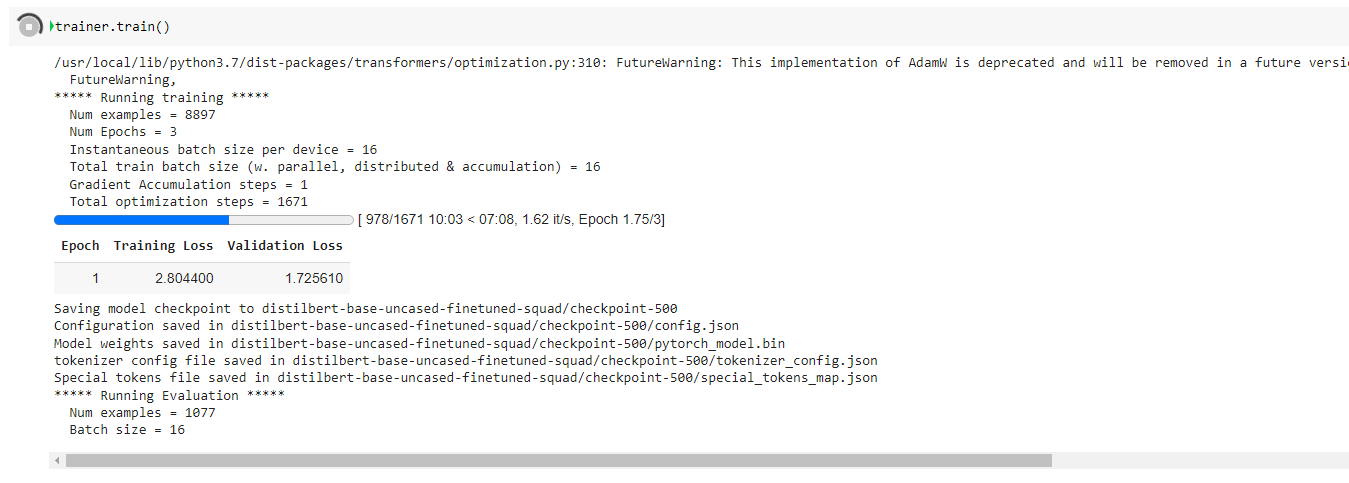

We can now finetune our model by just calling the `train` method:

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8897
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1671


Epoch,Training Loss,Validation Loss
1,2.945400,2.004356
2,1.666100,1.695221
3,1.241900,1.674791


Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-squad/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1077
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-squad/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-squad/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-squad/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-squad/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-sq

TrainOutput(global_step=1671, training_loss=1.866349800698847, metrics={'train_runtime': 1026.3941, 'train_samples_per_second': 26.005, 'train_steps_per_second': 1.628, 'total_flos': 2615446419715584.0, 'train_loss': 1.866349800698847, 'epoch': 3.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_dir = '/content/drive/MyDrive/KDM-ICP9'

Since this training is particularly long, let's save the model just in case we need to restart.

In [ ]:
trainer.save_model("{}/test-squad-trained-ICP".format(save_dir))

Saving model checkpoint to /content/drive/MyDrive/KDM-ICP9/test-squad-trained-ICP
Configuration saved in /content/drive/MyDrive/KDM-ICP9/test-squad-trained-ICP/config.json
Model weights saved in /content/drive/MyDrive/KDM-ICP9/test-squad-trained-ICP/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/KDM-ICP9/test-squad-trained-ICP/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/KDM-ICP9/test-squad-trained-ICP/special_tokens_map.json


In [ ]:
input()

i am good


'i am good'

Mounted at /content/drive


## Evaluation

Evaluating our model will require a bit more work, as we will need to map the predictions of our model back to parts of the context. The model itself predicts logits for the start and end position of our answers: if we take a batch from our validation dataloader, here is the output our model gives us:

In [ ]:
import torch

for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [ ]:
batch, output

({'input_ids': tensor([[ 101, 2029, 5088,  ...,    0,    0,    0],
          [ 101, 2029, 5088,  ...,    0,    0,    0],
          [ 101, 2073, 2106,  ...,    0,    0,    0],
          ...,
          [ 101, 2054, 2103,  ...,    0,    0,    0],
          [ 101, 2065, 3142,  ...,    0,    0,    0],
          [ 101, 3565, 4605,  ...,    0,    0,    0]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
  'start_positions': tensor([ 46,  57,  89,  43, 113, 107,  72,  35, 107,  34,  73,  41,  80,  91,
          156,  35], device='cuda:0'),
  'end_positions': tensor([ 47,  58,  92,  44, 113, 110,  75,  37, 110,  36,  76,  42,  83,  92,
          158,  35], device='cuda:0')},
 QuestionAnsweringModelOutput(loss=tensor(2.4312, device='cuda:0'), start_logits=tenso

The output of the model is a dict-like object that contains the loss (since we provided labels), the start and end logits. We won't need the loss for our predictions, let's have a look a the logits:

In [ ]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([16, 384]), torch.Size([16, 384]))

We have one logit for each feature and each token. The most obvious thing to predict an answer for each featyre is to take the index for the maximum of the start logits as a start position and the index of the maximum of the end logits as an end position.

In [ ]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 46,  57, 161,  54, 167, 162,  72, 160, 162, 159,  73,  52,  80,  80,
         156,  35], device='cuda:0'),
 tensor([ 47,  58,  17,  44, 171,  18,  75, 148,  18, 147,  76,  42,  83,  94,
         158,  35], device='cuda:0'))

This will work great in a lot of cases, but what if this prediction gives us something impossible: the start position could be greater than the end position, or point to a span of text in the question instead of the answer. In that case, we might want to look at the second best prediction to see if it gives a possible answer and select that instead.

However, picking the second best answer is not as easy as picking the best one: is it the second best index in the start logits with the best index in the end logits? Or the best index in the start logits with the second best index in the end logits? And if that second best answer is not possible either, it gets even trickier for the third best answer.


To classify our answers, we will use the score obtained by adding the start and end logits. We won't try to order all the possible answers and limit ourselves to with a hyper-parameter we call `n_best_size`. We'll pick the best indices in the start and end logits and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one. Here is how we would do this on the first feature in the batch:

In [ ]:
n_best_size = 20

In [ ]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

And then we can sort the `valid_answers` according to their `score` and only keep the best one. The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:
- the ID of the example that generated the feature (since each example can generate several features, as seen before);
- the offset mapping that will give us a map from token indices to character positions in the context.

That's why we will re-process the validation set with the following function, slightly different from `prepare_train_features`:

In [ ]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

And like before, we can apply that function to our validation set easily:

In [ ]:
# validation_features = datasets["validation"].map(
#     prepare_validation_features,
#     batched=True,
#     remove_columns=datasets["validation"].column_names
# )

validation_features = datasets[1].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets[1].column_names
)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
validation_features[0]

{'input_ids': [101,
  2029,
  5088,
  2136,
  3421,
  1996,
  10511,
  2012,
  3565,
  4605,
  2753,
  1029,
  102,
  3565,
  4605,
  2753,
  2001,
  2019,
  2137,
  2374,
  2208,
  2000,
  5646,
  1996,
  3410,
  1997,
  1996,
  2120,
  2374,
  2223,
  1006,
  5088,
  1007,
  2005,
  1996,
  2325,
  2161,
  1012,
  1996,
  2137,
  2374,
  3034,
  1006,
  10511,
  1007,
  3410,
  7573,
  14169,
  3249,
  1996,
  2120,
  2374,
  3034,
  1006,
  22309,
  1007,
  3410,
  3792,
  12915,
  2484,
  1516,
  2184,
  2000,
  7796,
  2037,
  2353,
  3565,
  4605,
  2516,
  1012,
  1996,
  2208,
  2001,
  2209,
  2006,
  2337,
  1021,
  1010,
  2355,
  1010,
  2012,
  11902,
  1005,
  1055,
  3346,
  1999,
  1996,
  2624,
  3799,
  3016,
  2181,
  2012,
  4203,
  10254,
  1010,
  2662,
  1012,
  2004,
  2023,
  2001,
  1996,
  12951,
  3565,
  4605,
  1010,
  1996,
  2223,
  13155,
  1996,
  1000,
  3585,
  5315,
  1000,
  2007,
  2536,
  2751,
  1011,
  11773,
  11107,
  1010,
  2004,
  2092,
  

Now we can grab the predictions for all features by using the `Trainer.predict` method:

In [ ]:
raw_predictions = trainer.predict(validation_features)

The following columns in the test set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1077
  Batch size = 16


The `Trainer` *hides* the columns that are not used by the model (here `example_id` and `offset_mapping` which we will need for our post-processing), so we set them back:

In [ ]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

We can now refine the test we had before: since we set `None` in the offset mappings when it corresponds to a part of the question, it's easy to check if an answer is fully inside the context. We also eliminate very long answers from our considerations (with an hyper-parameter we can tune)

In [ ]:
max_answer_length = 30

In [ ]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
# context = datasets["validation"][0]["context"]
context = datasets[1][0]["context"]


# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 10.802208, 'text': 'Denver Broncos'},
 {'score': 8.694986,
  'text': 'Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 7.649216, 'text': 'Carolina Panthers'},
 {'score': 6.897831, 'text': 'Broncos'},
 {'score': 5.353654, 'text': 'Denver'},
 {'score': 5.2905755,
  'text': 'American Football Conference (AFC) champion Denver Broncos'},
 {'score': 5.2569184,
  'text': 'National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos'},
 {'score': 4.7906094,
  'text': 'Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 4.2679033,
  'text': 'Denver Broncos defeated the National Football Conference (NFC) champion Carolina'},
 {'score': 4.0251403,
  'text': 'Denver Broncos defeated the National Football Conference (NFC'},
 {'score': 3.8851209,
  'text': 'Denver Broncos defeated the National Football Conference'},
 {'score': 3.863205,


We can compare to the actual ground-truth answer:

In [ ]:
# datasets["validation"][0]["answers"]
datasets[1][0]["answers"]


{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 'answer_start': [177, 177, 177]}

Our model picked the right as the most likely answer!

As we mentioned in the code above, this was easy on the first feature because we knew it comes from the first example. For the other features, we will need a map between examples and their corresponding features. Also, since one example can give several features, we will need to gather together all the answers in all the features generated by a given example, then pick the best one. The following code builds a map from example index to its corresponding features indices:

In [ ]:
import collections

# examples = datasets["validation"]
examples = datasets[1]

features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [ ]:
features_per_example

defaultdict(list,
            {0: [0],
             1: [1],
             2: [2],
             3: [3],
             4: [4],
             5: [5],
             6: [6],
             7: [7],
             8: [8],
             9: [9],
             10: [10],
             11: [11],
             12: [12],
             13: [13],
             14: [14],
             15: [15],
             16: [16],
             17: [17],
             18: [18],
             19: [19],
             20: [20],
             21: [21],
             22: [22],
             23: [23],
             24: [24],
             25: [25],
             26: [26],
             27: [27],
             28: [28],
             29: [29],
             30: [30],
             31: [31],
             32: [32],
             33: [33],
             34: [34],
             35: [35],
             36: [36],
             37: [37],
             38: [38],
             39: [39],
             40: [40],
             41: [41],
             42: [42],
             

We're almost ready for our post-processing function. The last bit to deal with is the impossible answer (when `squad_v2 = True`). The code above only keeps answers that are inside the context, we need to also grab the score for the impossible answer (which has start and end indices corresponding to the index of the CLS token). When one example gives several features, we have to predict the impossible answer when all the features give a high score to the impossible answer (since one feature could predict the impossible answer just because the answer isn't in the part of the context it has access too), which is why the score of the impossible answer for one example is the *minimum* of the scores for the impossible answer in each feature generated by the example.

We then predict the impossible answer when that score is greater than the score of the best non-impossible answer. All combined together, this gives us this post-processing function:

In [ ]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

And we can apply our post-processing function to our raw predictions:

In [ ]:
# final_predictions = postprocess_qa_predictions(datasets["validation"], validation_features, raw_predictions.predictions)
final_predictions = postprocess_qa_predictions(datasets[1], validation_features, raw_predictions.predictions)


Post-processing 1057 example predictions split into 1077 features.


  0%|          | 0/1057 [00:00<?, ?it/s]

Then we can load the metric from the datasets library.

In [ ]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


Then we can call compute on it. We just need to format predictions and labels a bit as it expects a list of dictionaries and not one big dictionary. In the case of squad_v2, we also have to set a `no_answer_probability` argument (which we set to 0.0 here as we have already set the answer to empty if we picked it).

In [ ]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
# references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets[1]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 61.68401135288553, 'f1': 69.66620357968463}

In [ ]:
references

[{'id': '56be4db0acb8001400a502ec',
  'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
   'answer_start': [177, 177, 177]}},
 {'id': '56be4db0acb8001400a502ed',
  'answers': {'text': ['Carolina Panthers',
    'Carolina Panthers',
    'Carolina Panthers'],
   'answer_start': [249, 249, 249]}},
 {'id': '56be4db0acb8001400a502ee',
  'answers': {'text': ['Santa Clara, California',
    "Levi's Stadium",
    "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."],
   'answer_start': [403, 355, 355]}},
 {'id': '56be4db0acb8001400a502ef',
  'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
   'answer_start': [177, 177, 177]}},
 {'id': '56be4db0acb8001400a502f0',
  'answers': {'text': ['gold', 'gold', 'gold'],
   'answer_start': [488, 488, 521]}},
 {'id': '56be8e613aeaaa14008c90d1',
  'answers': {'text': ['"golden anniversary"',
    'gold-themed',
    '"golden anniversary'],
   'answer_start': [487, 521, 487]}},
 {'id': '5

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained("sgugger/my-awesome-model")
```

#Assignment: Use another question-answering dataset to finetune your model.
* SQUAD-structured dataset is recommended (so you don't have to come up with your own pre-processing steps
* Use another base model
* Record metrics with F1 score.

# Another Base model

In [ ]:
# This flag is the difference between SQUAD v1 or 2 (if you're using another dataset, it indicates if impossible
# answers are allowed or not).
squad_v2 = False
model_checkpoint = "distilbert-base-cased"
batch_size = 16

In [ ]:
from datasets import load_dataset, load_metric

In [ ]:
# datasets = load_dataset("squad_v2" if squad_v2 else "squad") #full dataset
datasets = load_dataset("squad_v2" if squad_v2 else "squad",  split=['train[:10%]', 'validation[:10%]'])

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
datasets

[Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 8760
 }), Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 1057
 })]

In [ ]:
# datasets["train"][0]
datasets[0][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [ ]:
import random
# random.choice(datasets['train'])
random.choice(datasets[0])

{'id': '56cc08eb6d243a140015ee70',
 'title': 'Frédéric_Chopin',
 'context': 'On 3 December, Chopin complained about his bad health and the incompetence of the doctors in Majorca: "Three doctors have visited me ... The first said I was dead; the second said I was dying; and the third said I was about to die." He also had problems having his Pleyel piano sent to him. It finally arrived from Paris in December. Chopin wrote to Pleyel in January 1839: "I am sending you my Preludes [(Op. 28)]. I finished them on your little piano, which arrived in the best possible condition in spite of the sea, the bad weather and the Palma customs." Chopin was also able to undertake work on his Ballade No. 2, Op. 38; two Polonaises, Op. 40; and the Scherzo No. 3, Op. 39.',
 'question': 'What condition did Frédéric describe the piano that arrived to him through many dangerous obstacles?',
 'answers': {'text': ['best possible condition'], 'answer_start': [475]}}

In [ ]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))
    # display(df)

In [ ]:
# show_random_elements(datasets["train"])
show_random_elements(datasets[0])

,id,title,context,question,answers
0,56d4b9702ccc5a1400d83173,Beyoncé,"Beyoncé's first solo recording was a feature on Jay Z's ""'03 Bonnie & Clyde"" that was released in October 2002, peaking at number four on the U.S. Billboard Hot 100 chart. Her first solo album Dangerously in Love was released on June 24, 2003, after Michelle Williams and Kelly Rowland had released their solo efforts. The album sold 317,000 copies in its first week, debuted atop the Billboard 200, and has since sold 11 million copies worldwide. The album's lead single, ""Crazy in Love"", featuring Jay Z, became Beyoncé's first number-one single as a solo artist in the US. The single ""Baby Boy"" also reached number one, and singles, ""Me, Myself and I"" and ""Naughty Girl"", both reached the top-five. The album earned Beyoncé a then record-tying five awards at the 46th Annual Grammy Awards; Best Contemporary R&B Album, Best Female R&B Vocal Performance for ""Dangerously in Love 2"", Best R&B Song and Best Rap/Sung Collaboration for ""Crazy in Love"", and Best R&B Performance by a Duo or Group with Vocals for ""The Closer I Get to You"" with Luther Vandross.",When did Beyoncé release her first solo album?,"{'text': ['June 24, 2003'], 'answer_start': [229]}"
1,56d00bc5234ae51400d9c2ce,New_York_City,"Manhattan Island is linked to New York City's outer boroughs and New Jersey by several tunnels as well. The Lincoln Tunnel, which carries 120,000 vehicles a day under the Hudson River between New Jersey and Midtown Manhattan, is the busiest vehicular tunnel in the world. The tunnel was built instead of a bridge to allow unfettered passage of large passenger and cargo ships that sailed through New York Harbor and up the Hudson River to Manhattan's piers. The Holland Tunnel, connecting Lower Manhattan to Jersey City, New Jersey, was the world's first mechanically ventilated vehicular tunnel when it opened in 1927. The Queens-Midtown Tunnel, built to relieve congestion on the bridges connecting Manhattan with Queens and Brooklyn, was the largest non-federal project in its time when it was completed in 1940. President Franklin D. Roosevelt was the first person to drive through it. The Hugh L. Carey Tunnel runs underneath Battery Park and connects the Financial District at the southern tip of Manhattan to Red Hook in Brooklyn.",Who was the first person to drive through The Queens-Midtown Tunnel?,"{'text': ['President Franklin D. Roosevelt'], 'answer_start': [816]}"
2,56cef532aab44d1400b88d1b,New_York_City,"When one Republican presidential candidate for the 2016 election ridiculed the liberalism of ""New York values"" in January 2016, Donald Trump, leading in the polls, vigorously defended his city. The National Review, a conservative magazine published in the city since its founding by William F. Buckley, Jr. in 1955, commented, ""By hearkening back to New York's heart after 9/11, for a moment Trump transcended politics. How easily we forget, but for weeks after the terror attacks, New York was America.""",What public figure defended New York in January 2016?,"{'text': ['Donald Trump'], 'answer_start': [128]}"
3,56d61c4e1c85041400946f1a,2008_Sichuan_earthquake,"The Internet was extensively used for passing information to aid rescue and recovery efforts. For example, the official news agency Xinhua set up an online rescue request center in order to find the blind spots of disaster recovery. After knowing that rescue helicopters had trouble landing into the epicenter area in Wenchuan, a student proposed a landing spot online and it was chosen as the first touchdown place for the helicopters[not in citation given]. Volunteers also set up several websites to help store contact information for victims and evacuees. On May 31, a rescue helicopter carrying earthquake survivors and crew members crashed in fog and turbulence in Wenchuan county. No-one survived.",What was used as a communications aid in the relief efforts?,"{'text': ['The Internet'], 'answer_start': [0]}"
4,56c

# Preparing the training data

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/8d708decd7afb7bec0af233e5338fe1fca3db705/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 28996
}



Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/8d708decd7afb7bec0af233e5338fe1fca3db705/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/8d708decd7afb7bec0af233e5338fe1fca3db705/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/8d708decd7afb7bec0af233e5338fe1fca3db705/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/8d708decd7afb7bec0af233e5338fe1fca3db705/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "

In [ ]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [ ]:
tokenizer("Dd you recognize all your children?", "Sometimes I forget some of them.")

{'input_ids': [101, 141, 1181, 1128, 6239, 1155, 1240, 1482, 136, 102, 5875, 146, 5042, 1199, 1104, 1172, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [ ]:
for i, example in enumerate(datasets[0]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = datasets[0][i]

In [ ]:
example

{'id': '5733caf74776f4190066124c',
 'title': 'University_of_Notre_Dame',
 'context': "The men's basketball team has over 1,600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 NCAA tournaments. Former player Austin Carr holds the record for most points scored in a single game of the tournament with 61. Although the team has never won the NCAA Tournament, they were named by the Helms Athletic Foundation as national champions twice. The team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending UCLA's record 88-game winning streak in 1974. The team has beaten an additional eight number-one teams, and those nine wins rank second, to UCLA's 10, all-time in wins against the top team. The team plays in newly renovated Purcell Pavilion (within the Edmund P. Joyce Center), which reopened for the beginning of the 2009–2010 season. The team is coached by Mike Brey, who, as of the 2014–15 season, his fifteenth at Notre

In [ ]:
len(tokenizer(example["question"], example["context"])["input_ids"])

400

In [ ]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True, #contain some tokens from the end of the truncated sequence returned to provide some overlap between truncated and overflowing sequences.
    stride=doc_stride
)

In [ ]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 161]

In [ ]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] How many wins does the Notre Dame men's basketball team have? [SEP] The men's basketball team has over 1, 600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 NCAA tournaments. Former player Austin Carr holds the record for most points scored in a single game of the tournament with 61. Although the team has never won the NCAA Tournament, they were named by the Helms Athletic Foundation as national champions twice. The team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending UCLA's record 88 - game winning streak in 1974. The team has beaten an additional eight number - one teams, and those nine wins rank second, to UCLA's 10, all - time in wins against the top team. The team plays in newly renovated Purcell Pavilion ( within the Edmund P. Joyce Center ), which reopened for the beginning of the 2009 – 2010 season. The team is coached by Mike Brey, who, as of the 2014 – 15 season, his fifteenth at Notr

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (4, 8), (9, 13), (14, 18), (19, 22), (23, 28), (29, 33), (34, 37), (37, 38), (38, 39), (40, 50), (51, 55), (56, 60), (60, 61), (0, 0), (0, 3), (4, 7), (7, 8), (8, 9), (10, 20), (21, 25), (26, 29), (30, 34), (35, 36), (36, 37), (37, 40), (41, 45), (45, 46), (47, 50), (51, 53), (54, 58), (59, 61), (62, 69), (70, 73), (74, 78), (79, 86), (87, 91), (92, 96), (96, 97), (98, 101), (102, 106), (107, 115), (116, 118), (119, 121), (122, 126), (127, 138), (138, 139), (140, 146), (147, 153), (154, 160), (161, 165), (166, 171), (172, 175), (176, 182), (183, 186), (187, 191), (192, 198), (199, 205), (206, 208), (209, 210), (211, 217), (218, 222), (223, 225), (226, 229), (230, 240), (241, 245), (246, 248), (248, 249), (250, 258), (259, 262), (263, 267), (268, 271), (272, 277), (278, 281), (282, 285), (286, 290), (291, 301), (301, 302), (303, 307), (308, 312), (313, 318), (319, 321), (322, 325), (326, 328), (328, 330), (330, 331), (332, 340), (341, 351), (352, 354), (355, 363), (364,

In [ ]:
first_token_id = tokenized_example["input_ids"][0][3]
offsets = tokenized_example["offset_mapping"][0][3]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

wins wins


In [ ]:
random_idx = random.randint(1, 10)
random_token_id = tokenized_example["input_ids"][0][random_idx]
offsets = tokenized_example["offset_mapping"][0][random_idx]
print(tokenizer.convert_ids_to_tokens([random_token_id])[0], example["question"][offsets[0]:offsets[1]])

many many


In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])
print('Start Char', start_char)
print('End Char', end_char)

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char): #makes sure it contains the answer
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print('Token Offset: ', start_position, end_position)
else:
    print("The answer is not in this feature.")

Start Char 30
End Char 40
Token Offset:  23 26


In [ ]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

over 1, 600
over 1,600


In [ ]:
pad_on_right = tokenizer.padding_side == "right"
pad_on_right

True

In [ ]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")
    # print('Offset mapping: ', offset_mapping)

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
features = prepare_train_features(datasets[0][:5])
features

{'input_ids': [[101, 1706, 2292, 1225, 1103, 6567, 2090, 9273, 2845, 1107, 8109, 1107, 10111, 20500, 1699, 136, 102, 22182, 1193, 117, 1103, 1278, 1144, 170, 2336, 1959, 119, 1335, 4184, 1103, 4304, 4334, 112, 188, 2284, 10945, 1110, 170, 5404, 5921, 1104, 1103, 6567, 2090, 119, 13301, 1107, 1524, 1104, 1103, 4304, 4334, 1105, 4749, 1122, 117, 1110, 170, 7335, 5921, 1104, 4028, 1114, 1739, 1146, 14089, 5591, 1114, 1103, 7051, 107, 159, 21462, 1566, 24930, 2508, 152, 1306, 3965, 107, 119, 5893, 1106, 1103, 4304, 4334, 1110, 1103, 19349, 1104, 1103, 11373, 4641, 119, 13301, 1481, 1103, 171, 17506, 9538, 1110, 1103, 144, 10595, 2430, 117, 170, 14789, 1282, 1104, 8070, 1105, 9284, 119, 1135, 1110, 170, 16498, 1104, 1103, 176, 10595, 2430, 1120, 10111, 20500, 117, 1699, 1187, 1103, 6567, 2090, 25153, 1193, 1691, 1106, 2216, 17666, 6397, 3786, 1573, 25422, 13149, 1107, 8109, 119, 1335, 1103, 1322, 1104, 1103, 1514, 2797, 113, 1105, 1107, 170, 2904, 1413, 1115, 8200, 1194, 124, 11739, 1105, 1

In [ ]:
datasets

[Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 8760
 }), Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 1057
 })]

In [ ]:
tokenized_datasets_train = datasets[0].map(prepare_train_features, batched=True, remove_columns=datasets[0].column_names)
tokenized_datasets_val = datasets[1].map(prepare_train_features, batched=True, remove_columns=datasets[1].column_names)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

# Fine tuning model

In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/8d708decd7afb7bec0af233e5338fe1fca3db705/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 28996
}



Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/8d708decd7afb7bec0af233e5338fe1fca3db705/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswerin

In [ ]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False, #True will need tokens
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8918
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1674


Epoch,Training Loss,Validation Loss
1,3.051500,2.160335
2,1.824500,1.980064
3,1.437600,1.986703


Saving model checkpoint to distilbert-base-cased-finetuned-squad/checkpoint-500
Configuration saved in distilbert-base-cased-finetuned-squad/checkpoint-500/config.json
Model weights saved in distilbert-base-cased-finetuned-squad/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-cased-finetuned-squad/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-cased-finetuned-squad/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1082
  Batch size = 16
Saving model checkpoint to distilbert-base-cased-finetuned-squad/checkpoint-1000
Configuration saved in distilbert-base-cased-finetuned-squad/checkpoint-1000/config.json
Model weights saved in distilbert-base-cased-finetuned-squad/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distilbert-base-cased-finetuned-squad/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distilbert-base-cased-finetuned-squad/checkpoint-1000/

TrainOutput(global_step=1674, training_loss=2.0256776524843425, metrics={'train_runtime': 1025.6901, 'train_samples_per_second': 26.084, 'train_steps_per_second': 1.632, 'total_flos': 2621619778692096.0, 'train_loss': 2.0256776524843425, 'epoch': 3.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
trainer.save_model("{}/test-squad-trained-ICP9".format(save_dir))

Saving model checkpoint to /content/drive/MyDrive/KDM-ICP9/test-squad-trained-ICP9
Configuration saved in /content/drive/MyDrive/KDM-ICP9/test-squad-trained-ICP9/config.json
Model weights saved in /content/drive/MyDrive/KDM-ICP9/test-squad-trained-ICP9/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/KDM-ICP9/test-squad-trained-ICP9/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/KDM-ICP9/test-squad-trained-ICP9/special_tokens_map.json


In [ ]:
input()

i am good


'i am good'

# Evaluation

In [ ]:
import torch

for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [ ]:
batch, output

({'input_ids': tensor([[ 101, 5979, 4279,  ...,    0,    0,    0],
          [ 101, 5979, 4279,  ...,    0,    0,    0],
          [ 101, 2777, 1225,  ...,    0,    0,    0],
          ...,
          [ 101, 1327, 1331,  ...,    0,    0,    0],
          [ 101, 1409, 2264,  ...,    0,    0,    0],
          [ 101, 3198, 5308,  ...,    0,    0,    0]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
  'start_positions': tensor([ 46,  57,  89,  43, 113, 107,  72,  35, 107,  34,  73,  41,  80,  91,
          157,  35], device='cuda:0'),
  'end_positions': tensor([ 47,  58,  92,  44, 113, 110,  75,  37, 110,  36,  76,  42,  83,  92,
          159,  35], device='cuda:0')},
 QuestionAnsweringModelOutput(loss=tensor(2.3808, device='cuda:0'), start_logits=tenso

In [ ]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([16, 384]), torch.Size([16, 384]))

In [ ]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 46,  46,  98,  54, 113,  99,  72,  42,  99,  41,  99,  96,  80,  86,
         157,  35], device='cuda:0'),
 tensor([ 47,  47,  81,  58, 118,  99,  75,  43,  99,  42,  99,  96,  83,  83,
         159,  35], device='cuda:0'))

In [ ]:
n_best_size = 20

In [ ]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

In [ ]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
validation_features = datasets[1].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets[1].column_names
)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
validation_features[0]

{'input_ids': [101,
  5979,
  4279,
  1264,
  2533,
  1103,
  10402,
  1120,
  3198,
  5308,
  1851,
  136,
  102,
  3198,
  5308,
  1851,
  1108,
  1126,
  1237,
  1709,
  1342,
  1106,
  4959,
  1103,
  3628,
  1104,
  1103,
  1305,
  2289,
  1453,
  113,
  4279,
  114,
  1111,
  1103,
  1410,
  1265,
  119,
  1109,
  1237,
  2289,
  3047,
  113,
  10402,
  114,
  3628,
  7068,
  14722,
  2378,
  1103,
  1305,
  2289,
  3047,
  113,
  24743,
  114,
  3628,
  2938,
  13598,
  1572,
  782,
  1275,
  1106,
  7379,
  1147,
  1503,
  3198,
  5308,
  1641,
  119,
  1109,
  1342,
  1108,
  1307,
  1113,
  1428,
  128,
  117,
  1446,
  117,
  1120,
  12388,
  112,
  188,
  3339,
  1107,
  1103,
  1727,
  2948,
  2410,
  3894,
  1120,
  3364,
  10200,
  117,
  1756,
  119,
  1249,
  1142,
  1108,
  1103,
  13163,
  3198,
  5308,
  117,
  1103,
  2074,
  13463,
  1103,
  107,
  5404,
  5453,
  107,
  1114,
  1672,
  2284,
  118,
  12005,
  11751,
  117,
  1112,
  1218,
  1112,
  7818,
  28117,

In [ ]:
raw_predictions = trainer.predict(validation_features)

The following columns in the test set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1082
  Batch size = 16


In [ ]:
max_answer_length = 30

In [ ]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
# context = datasets["validation"][0]["context"]
context = datasets[1][0]["context"]


# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 7.412736, 'text': 'Denver Broncos'},
 {'score': 4.3909655,
  'text': 'The American Football Conference (AFC) champion Denver Broncos'},
 {'score': 4.3767242,
  'text': 'American Football Conference (AFC) champion Denver Broncos'},
 {'score': 3.6456456,
  'text': 'Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10'},
 {'score': 3.1925337, 'text': 'Denver'},
 {'score': 2.745091, 'text': 'Broncos'},
 {'score': 2.5165806,
  'text': '2015 season. The American Football Conference (AFC) champion Denver Broncos'},
 {'score': 1.9229095,
  'text': 'American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos'},
 {'score': 1.8786612,
  'text': 'National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos'},
 {'score': 1.7312701,
  'text': 'Denver Broncos defeated the National Foot

In [ ]:
datasets[1][0]["answers"]

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 'answer_start': [177, 177, 177]}

In [ ]:
import collections

# examples = datasets["validation"]
examples = datasets[1]

features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [ ]:
features_per_example

defaultdict(list,
            {0: [0],
             1: [1],
             2: [2],
             3: [3],
             4: [4],
             5: [5],
             6: [6],
             7: [7],
             8: [8],
             9: [9],
             10: [10],
             11: [11],
             12: [12],
             13: [13],
             14: [14],
             15: [15],
             16: [16],
             17: [17],
             18: [18],
             19: [19],
             20: [20],
             21: [21],
             22: [22],
             23: [23],
             24: [24],
             25: [25],
             26: [26],
             27: [27],
             28: [28],
             29: [29],
             30: [30],
             31: [31],
             32: [32],
             33: [33],
             34: [34],
             35: [35],
             36: [36],
             37: [37],
             38: [38],
             39: [39],
             40: [40],
             41: [41],
             42: [42],
             

In [ ]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [ ]:
final_predictions = postprocess_qa_predictions(datasets[1], validation_features, raw_predictions.predictions)

Post-processing 1057 example predictions split into 1082 features.


  0%|          | 0/1057 [00:00<?, ?it/s]

In [ ]:
metric = load_metric("squad_v2" if squad_v2 else "squad")

# F1 Score

In [ ]:
if squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
# references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets[1]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 54.77767265846736, 'f1': 61.55601817051037}

In [ ]:
references

[{'id': '56be4db0acb8001400a502ec',
  'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
   'answer_start': [177, 177, 177]}},
 {'id': '56be4db0acb8001400a502ed',
  'answers': {'text': ['Carolina Panthers',
    'Carolina Panthers',
    'Carolina Panthers'],
   'answer_start': [249, 249, 249]}},
 {'id': '56be4db0acb8001400a502ee',
  'answers': {'text': ['Santa Clara, California',
    "Levi's Stadium",
    "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."],
   'answer_start': [403, 355, 355]}},
 {'id': '56be4db0acb8001400a502ef',
  'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
   'answer_start': [177, 177, 177]}},
 {'id': '56be4db0acb8001400a502f0',
  'answers': {'text': ['gold', 'gold', 'gold'],
   'answer_start': [488, 488, 521]}},
 {'id': '56be8e613aeaaa14008c90d1',
  'answers': {'text': ['"golden anniversary"',
    'gold-themed',
    '"golden anniversary'],
   'answer_start': [487, 521, 487]}},
 {'id': '5

# Using different dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/KDM-ICP9/alzheimer_questionaire.csv", encoding='latin1', on_bad_lines='skip')
df

,ï»¿question,answer
0,Did you feel that you forget something?,Sometimes I forget some matters
1,"If so, is it happening more than one year?",It is happening for several years
2,Did you repeat some works again and again,I am very good at gardening
3,How you manage your appoinments? Did you keep ...,I go to park everyday
4,How do you keep your house chores? Do you arra...,I always keep in my arrangement
...,...,...
157,NaN,NaN
158,NaN,NaN
159,NaN,NaN
160,NaN,NaN


In [ ]:
df = df[0:50]
df

,ï»¿question,answer
0,Did you feel that you forget something?,Sometimes I forget some matters
1,"If so, is it happening more than one year?",It is happening for several years
2,Did you repeat some works again and again,I am very good at gardening
3,How you manage your appoinments? Did you keep ...,I go to park everyday
4,How do you keep your house chores? Do you arra...,I always keep in my arrangement
5,Do you suspect someone is conspiring or steali...,I think my daughter in law is conpiring.
6,When is your birthday?,I am very good at gardening
7,Do you like new places?,"Every Sunday, I cook"
8,What you do when you travel?,I always take picture
9,Do you prefer to count money?,I always love reading


In [ ]:
df.columns = df.columns.str.replace('ï»¿question', 'question')
df

,question,answer
0,Did you feel that you forget something?,Sometimes I forget some matters
1,"If so, is it happening more than one year?",It is happening for several years
2,Did you repeat some works again and again,I am very good at gardening
3,How you manage your appoinments? Did you keep ...,I go to park everyday
4,How do you keep your house chores? Do you arra...,I always keep in my arrangement
5,Do you suspect someone is conspiring or steali...,I think my daughter in law is conpiring.
6,When is your birthday?,I am very good at gardening
7,Do you like new places?,"Every Sunday, I cook"
8,What you do when you travel?,I always take picture
9,Do you prefer to count money?,I always love reading


In [ ]:
# This flag is the difference between SQUAD v1 or 2 (if you're using another dataset, it indicates if impossible
# answers are allowed or not).
squad_v2 = False
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

In [ ]:
import random
# random.choice(datasets['train'])
random.choice(df['question'])

'Do you feel that your situation is hopeless?'

In [ ]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))
    # display(df)


In [ ]:
show_random_elements(df)

KeyError: ignored

# Preprocessing the training data

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

In [ ]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [ ]:
tokenizer("Can you remember who is your eldest son?")

{'input_ids': [101, 2064, 2017, 3342, 2040, 2003, 2115, 7310, 2365, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
max_length = 250 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [ ]:
for i, example in enumerate(df['question']):
    if len(tokenizer(example["question"], example["answer"])["question"]) > 250:
        break
example = df['question'][i]

TypeError: ignored

In [ ]:
example

'Did you feel that you forget something?'

In [ ]:
len(tokenizer(example["question"], example["answer"])["question"])

TypeError: ignored

In [ ]:
len(tokenizer(example["question"], example["answer"], max_length=max_length, truncation="only_second")["answer"])


TypeError: ignored

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["answer"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True, #contain some tokens from the end of the truncated sequence returned to provide some overlap between truncated and overflowing sequences.
    stride=doc_stride
)

TypeError: ignored

In [ ]:
[len(x) for x in tokenized_example["answer"]]

KeyError: ignored

In [ ]:
for x in tokenized_example["question"][:2]:
    print(tokenizer.decode(x))

KeyError: ignored